In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pyro.distributions as dist
from torch import Tensor
from torch.autograd import Variable

# pyro functions we probably won't use to get w and b

In [74]:
mu = Variable(Tensor([0.]))
sigma = Variable(Tensor([1.23]))
get_w = lambda: dist.normal(mu, sigma).data[0]
get_b = lambda: dist.normal(mu, sigma).data[0]

# yeah let's just generate some lines with identity covariance matrix and non-identity

In [2]:
mu = np.zeros(2)
x = np.linspace(-10, 10, 200)


def plot_lines(cov, mu=mu, ylim=(-25, 25)):
    
    # Set up figure
    plt.figure(figsize=(10, 6))
    plt.ylim(*ylim)
    plt.xlim(-10, 10)

    for _ in range(100):

        # Draw bias weight
        bias, weight = np.random.multivariate_normal(mu, cov)
        
        # Compute function output
        y = weight * x + bias
        
        plt.plot(x, y)

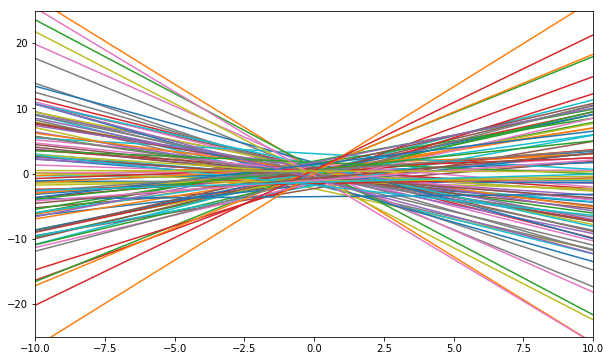

In [3]:
plot_lines(cov=np.eye(2))

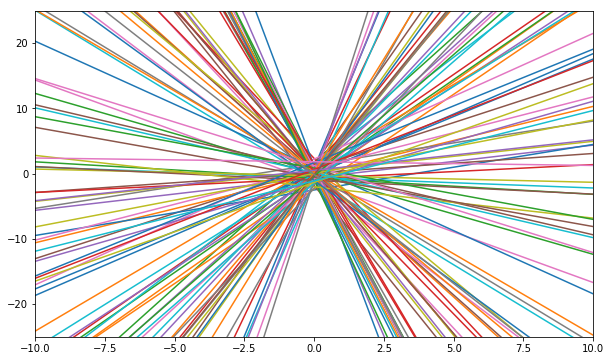

In [4]:
plot_lines(cov=np.diag([1, 30]))

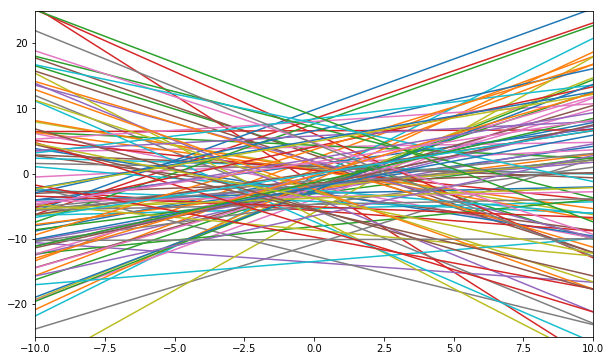

In [5]:
plot_lines(cov=np.diag([30, 1]))

# Define some crazy function

In [6]:
y_true = np.sin(x)**2 - np.abs(x - 3) + 7
y_true_ = y_true + .5 * np.random.randn(len(y_true))

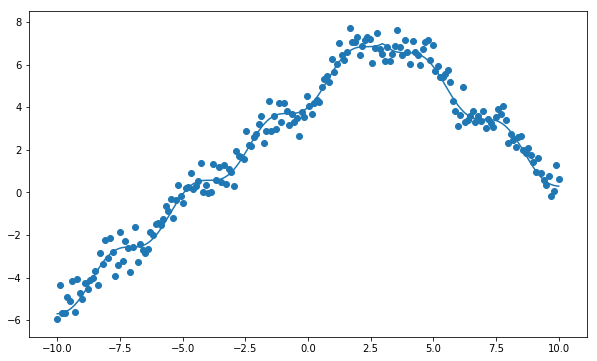

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(x, y_true)
plt.scatter(x, y_true_)

# gaussian processes

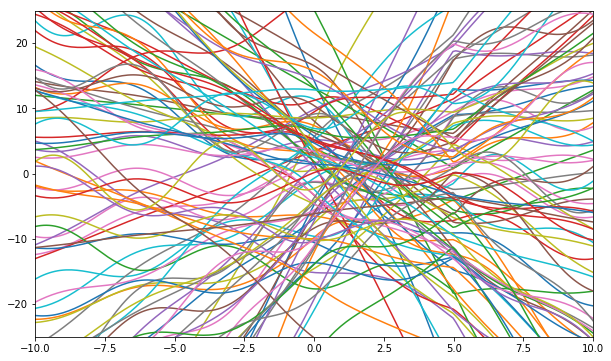

In [32]:
# weights
mu_w = np.zeros(5)
cov_w = np.diag(np.exp(np.random.randn(5)))

# features
features = np.array([np.ones_like(x), x, np.tanh(x), -np.cos(x), np.abs(x - 5)])


def plot_function_evals(mu_w, cov_w, features, n_samples=100):
    plt.figure(figsize=(10, 6))
    plt.ylim(-25, 25)
    plt.xlim(-10, 10)

    for _ in range(n_samples):
        w = np.random.multivariate_normal(mu_w, cov_w)
        mu_y = features.T @ w
        cov_y = features.T @ cov_w @ features
        y = np.random.multivariate_normal(mu_y, cov_y)
        plt.plot(x, y)
        
plot_function_evals(mu_w, cov_w, features)

/Users/willwolf/anaconda3/envs/pyro/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: covariance is not positive-semidefinite.


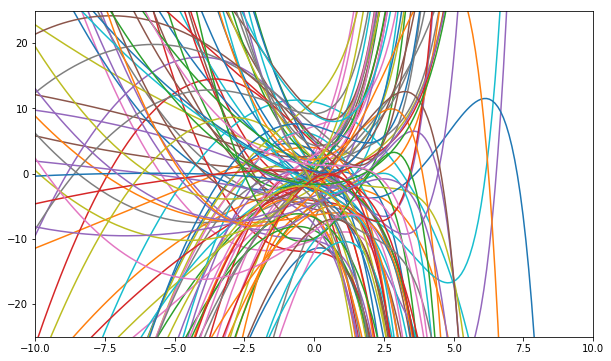

In [33]:
features = np.array([np.exp(x), x - 1, x, x**2, 1.2345*np.ones_like(x)])

plot_function_evals(mu_w, cov_w, features)

# RBF

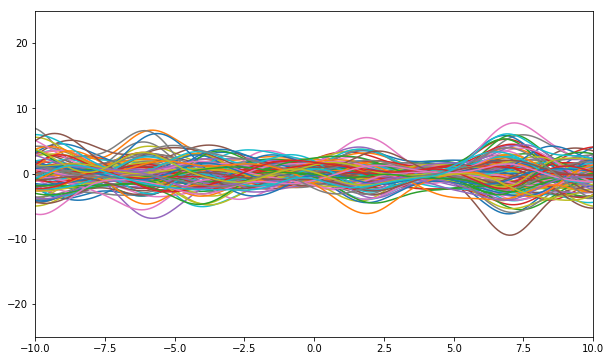

In [114]:
D = BIG_NUMBER = 198

mu_w = np.zeros(D)
cov_w = np.diag(np.exp(np.random.randn(D)))
features = np.array([np.exp(-.5 * (x - d)**2) for d in range(int(-D / 2), int(D / 2))])

plot_function_evals(mu_w, cov_w, features)

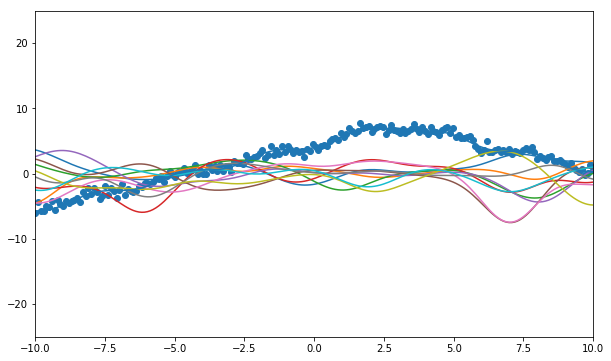

In [115]:
plot_function_evals(mu_w, cov_w, features, n_samples=10)

plt.plot(x, y_true)
plt.scatter(x, y_true_)

# This whole covariance business

In [116]:
# D = 7
# N_OBS = 12

# mu_w = np.random.randn(D)

# 1. we can just make this ourselves:
#    - how does each of the 7 dimensions covary with every other dimension?
#    - for this reason, the thing will always be of size 7 x 7
# 2. we can estimate this from data
#    - numpy docs say: "m : array_like; A 1-D or 2-D array containing multiple variables 
#      and observations. Each row of m represents a variable, and each column a single 
#      observation of all those variables."
#    - this is backwards from what we typically think. nonetheless, our input to np.cov
#      should be of size (D, N_OBS)

# cov_w = np.cov(np.random.randn(D, N_OBS))

# N_OBS_X = 100

# mu_y = np.random.randn(N_OBS_X)  # after passing it through the mean function, which collapses the dimensionality D to 1
# phi_x = np.random.randn(D, N_OBS_X)  # same as above, with D first then N_OBS_X
# cov_y = phi_x.T @ cov_w @ phi_x  # 100 x 100; # we often just compute this directly with RBF kernel; this is the explicit way, which is of course infeasible if `phi` gives inf features!

# # now pluck out your things
# cov_w_y = cov_w @ phi_x  # (7 x 7) @ (7, 100) --> 7, 100
# cov_y_x = phi_x.T @ cov_w  # (100 x 7) @ (7, 7) --> 100, 7

# Posterior distributions

# $P(w\vert y)$

In [120]:
def plot_posterior_function_evals(mu_w, cov_w, features, y_true, n_samples=100):
    plt.figure(figsize=(10, 6))
    plt.ylim(-25, 25)
    plt.xlim(-10, 10)
    
#     for _ in range(n_samples):
    # sample from prior, as before
#         w = np.random.multivariate_normal(mu_w, cov_w)
    w = np.zeros_like(mu_w)

    # compute likelihood parameters, as before
    mu_y = features.T @ w
    cov_y = features.T @ cov_w @ features

    # compute parameters of posterior weight distribution
    mu_w = mu_w + cov_w @ features @ np.linalg.inv(cov_y) @ (y_true - mu_y)
    cov_w = cov_w - cov_w @ features @ np.linalg.inv(cov_y) @ features.T @ cov_w

    # draw from posterior weight distribution
#         w = np.random.multivariate_normal(mu_w, cov_w)
    w = np.zeros_like(mu_w)

    # compose posterior likelihood parameters
    mu_y = features.T @ w
    cov_y = features.T @ cov_w @ features
    y = np.random.multivariate_normal(mu_y, cov_y)
    plt.errorbar(x, y, yerr=np.diag(cov_y), capsize=0)
    plt.plot(x, y_true, 'ro')

/Users/willwolf/anaconda3/envs/pyro/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: covariance is not positive-semidefinite.


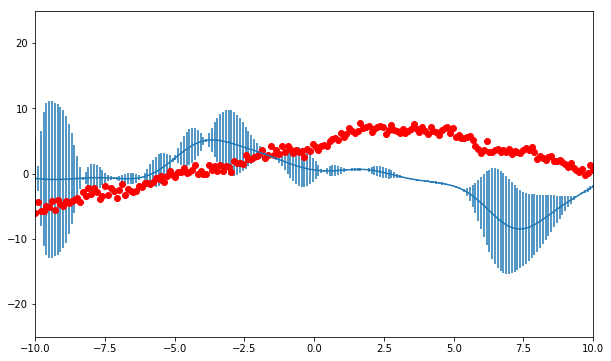

In [121]:
plot_posterior_function_evals(mu_w, cov_w, features, y_true_)

# $P(y^{*}\vert y)$

(just multiply phi(x_new) through the mean, and wrapped around the covariance)

In [70]:
N_OBS_X_NEW = 133
phi_x_new = np.random.randn(D, N_OBS_X_NEW)


mu_new_y = np.random.randn(N_OBS_X_NEW)  # (133), this is after passing it through the mean function!
cov_new_y = phi_x_new.T @ cov_new @ phi_x_new  # 133 x 133

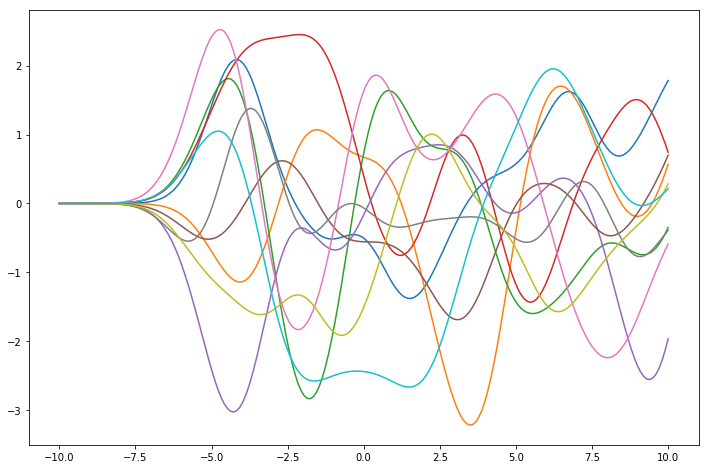

In [45]:
plt.figure(figsize=(12, 8))

for c in range(10):
    color = f'C{c}'
    ys = np.random.multivariate_normal(mean, kernel)
    plt.plot(x, ys, color=color)
# plt.show(p)

In [46]:
# Posterior over function evaluations for new data

x_new = np.random.randn(17)
features_new = featurize(x_new)

mean_post = mean_func(params, features_new)
A = cov_kernel(features_new, features, sigma)
B = cov_kernel(features_new, features_new, sigma)
C = cov_kernel(features, features, sigma)
# mean_post += A.dot

In [47]:
A.shape

(17, 200)

In [48]:
B.shape

(17, 17)

In [49]:
C.shape

(200, 200)

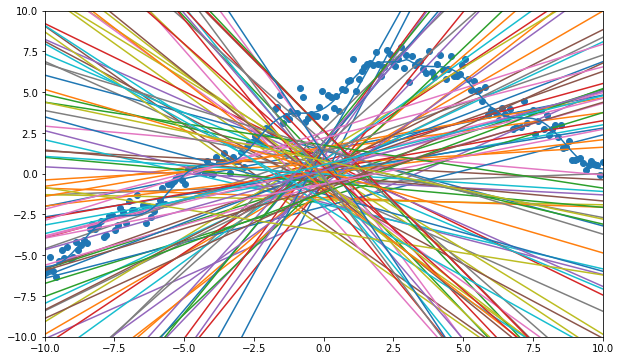

In [52]:
plt.figure(figsize=(10, 6))
plt.ylim(-10, 10)
plt.xlim(-10, 10)
for y in Y:
    plt.plot(x, y)
plt.plot(x, y_true)
plt.scatter(x, noisy_y_true)

In [53]:
# import pandas as pd

# df = pd.DataFrame({'noisy_y_true': noisy_y_true}, index=x)

data = {xx: yy for xx, yy in zip(x, noisy_y_true)}

# kernel regression

In [54]:
# rbf kernel
def rbf(point, neighbor, sigma=.5):
    return np.exp(-(point - neighbor)**2 / (2 * sigma**2))


def query(point, data=data, kernel=rbf):
    weighted_sum = 0
    total_weight = 0
    for x, y in data.items():
        if x != point:
            weight = kernel(point=point, neighbor=x)
            weighted_sum += weight * y
            total_weight += weight
    return weighted_sum / total_weight

In [55]:
y_approx = [query(xx) for xx in x]

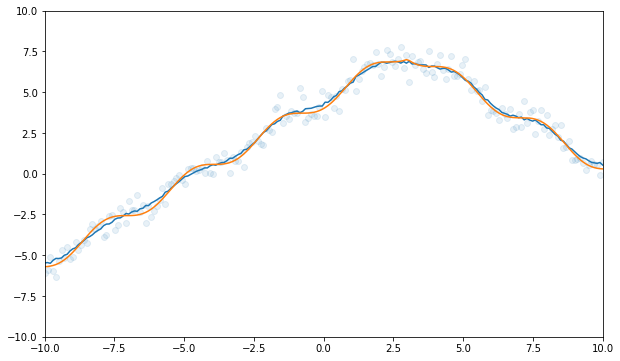

In [56]:
plt.figure(figsize=(10, 6))
plt.ylim(-10, 10)
plt.xlim(-10, 10)
plt.plot(x, y_approx)
plt.plot(x, y_true)
plt.scatter(x, noisy_y_true, alpha=.1)

In [57]:
# projections = np.array([x, np.sin(x), np.cos(x), np.tanh(x)]).T
projections = np.array([x, np.abs(x-2), np.abs(x-5), x-20]).T

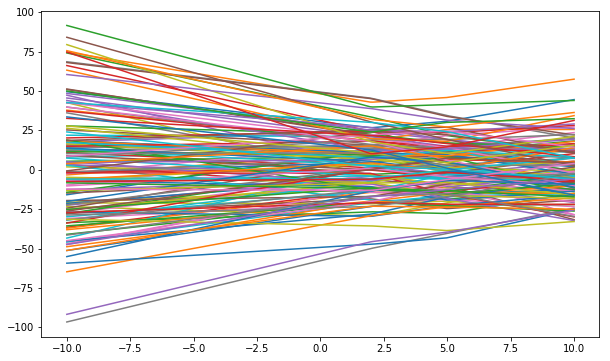

In [58]:
plt.figure(figsize=(10, 6))
# plt.ylim(0, 10)
# plt.xlim(0, 10)
for _ in range(145):
    y = projections @ np.random.randn(4)
    plt.plot(x, y)

In [59]:
# Mean function

n_features = 10
evl = 7  # number of data points at which i want to evaluate

x_new = np.random.randn(evl, n_features)
mu = np.random.randn(10)  # mean of the weights prior

mean_func_eval = x_new @ mu  # the thing we put into the posterior over function evaluations

In [60]:
# Plot some mv-normal draws using an RBF kernel

In [94]:
# def k(xs, ys, sigma=1, l=1):
#     """Sqared Exponential kernel as above but designed to return the whole
#     covariance matrix - i.e. the pairwise covariance of the vectors xs & ys.
#     Also with two parameters which are discussed at the end."""

#     # Pairwise difference matrix.
#     dx = np.expand_dims(xs, 1) - np.expand_dims(ys, 0)
#     return (sigma ** 2) * np.exp(-((dx / l) ** 2) / 2)

# def m(x):
#     """The mean function. As discussed, we can let the mean always be zero."""
#     return np.zeros_like(x)